<a href="https://colab.research.google.com/github/ZhaoQii/IST597/blob/main/IST597_HW3_Builtin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#np.random.seed(1178)
#tf.random.set_seed(1178)

In [ ]:
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn import preprocessing
(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train_fs, y_train_fs), (X_test_fs, y_test_fs) = fashion_mnist.load_data()

# first way to normalize data
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

X_train = X_train.reshape([X_train.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

X_train_fs = X_train_fs.astype(float) / 255.
X_test_fs = X_test_fs.astype(float) / 255.

X_train_fs = X_train_fs.reshape([X_train_fs.shape[0], -1])
X_test_fs = X_test_fs.reshape([X_test_fs.shape[0], -1])

# one hot
onehot = preprocessing.OneHotEncoder()

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

onehot.fit(y_train)
y_train = onehot.transform(y_train).toarray()
onehot.fit(y_test)
y_test = onehot.transform(y_test).toarray()

y_train_fs = y_train_fs.reshape(-1, 1)
y_test_fs = y_test_fs.reshape(-1, 1)

onehot.fit(y_train_fs)
y_train_fs = onehot.transform(y_train_fs).toarray()
onehot.fit(y_test_fs)
y_test_fs = onehot.transform(y_test_fs).toarray()

# validation set
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]

X_train_fs, X_val_fs = X_train_fs[:-10000], X_train_fs[-10000:]
y_train_fs, y_val_fs = y_train_fs[:-10000], y_train_fs[-10000:]

4431872/4422102 [==============================] - 0s 0us/step


## Define Class

In [ ]:
X_val.shape

(10000, 784)

In [ ]:
# Define class to build mlp model
class MLP_QZ(object):
  def __init__(self, size_data, size_input, size_hidden_1, size_hidden_2, size_output, device = None, regularizer = None,
               L1_alpha = 0., L2_alpha = 0., optimizer = 'SGD', lr = 1e-4):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_data, self.size_input, self.size_hidden_1, self.size_hidden_2, self.size_output, self.device, self.regularizer, \
    self.L1_alpha, self.L2_alpha, self.optimizer, self.lr = \
    size_data, size_input, size_hidden_1, size_hidden_2, size_output, device, regularizer, L1_alpha, L2_alpha, \
    optimizer, lr
    
    # Xavier initialization
    initializer = tf.initializers.GlorotUniform()

    self.W0 = tf.Variable(initializer(shape = [self.size_data, self.size_input]))
    #self.W0 = tf.Variable(tf.random.normal([self.size_data, self.size_input], stddev = 0.1))
    self.b0 = tf.Variable(tf.zeros([1, self.size_input]))

    self.W1 = tf.Variable(initializer(shape = [self.size_input, self.size_hidden_1]))
    #self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden_1], stddev = 0.1))
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden_1]))

    self.W2 = tf.Variable(initializer(shape = [self.size_hidden_1, self.size_hidden_2]))
    #self.W2 = tf.Variable(tf.random.normal([self.size_hidden_1, self.size_hidden_2], stddev = 0.1))
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden_2]))

    self.W3 = tf.Variable(initializer(shape = [self.size_hidden_2, self.size_output]))
    #self.W3 = tf.Variable(tf.random.normal([self.size_hidden_2, self.size_output], stddev = 0.1))
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W0, self.W1, self.W2, self.W3, self.b0, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    #return tf.losses.categorical_crossentropy(y_true_tf, y_pred_tf, from_logits = False)
    ce = tf.keras.losses.CategoricalCrossentropy(from_logits = True)

    if self.regularizer is None:
      return ce(y_true_tf, y_pred_tf)
    elif self.regularizer == 'L1':
      return (ce(y_true_tf, y_pred_tf) + self.L1_alpha * sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]))
    elif self.regularizer == 'L2':
      return (ce(y_true_tf, y_pred_tf) + self.L2_alpha * sum([tf.nn.l2_loss(var) for var in self.variables]))
    elif self.regularizer == 'L1 + L2':
      return (ce(y_true_tf, y_pred_tf) + self.L1_alpha * sum([tf.reduce_sum(tf.abs(var)) for var in self.variables]) + self.L2_alpha * sum([tf.nn.l2_loss(var) for var in self.variables]))
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    #print(grads[0])
    if self.optimizer == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate = self.lr)
    elif self.optimizer == 'Adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate = self.lr)
    elif self.optimizer == 'RMSEProp':
      optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.lr)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)    
    # Compute values in the first hidden layer
    what_0 = tf.matmul(X_tf, self.W0) + self.b0
    hhat_0 = tf.nn.relu(what_0)
    # Compute values in the first hidden layer
    what_1 = tf.matmul(hhat_0, self.W1) + self.b1
    hhat_1 = tf.nn.relu(what_1)
    # Compute values in the second hidden layer
    what_2 = tf.matmul(hhat_1, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)
    # Compute output
    output = tf.matmul(hhat_2, self.W3) + self.b3
    #output = tf.nn.softmax(what_3)
    return output

## Train Model

In [ ]:
size_data, size_input, size_hidden_1, size_hidden_2, size_output = 28 * 28, 512, 256, 128, 10 
batch_size_train = 128
batch_size_val = 16
batch_size_test = 16

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

# Initialize model
# , regularizer = 'L2', L1_alpha = 1 , regularizer = 'L2', L1_alpha = 1 , device='gpu' optimizer = 'Adam', 
mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, lr = 1e-2, optimizer = 'SGD', device = 'gpu', regularizer = 'L2', L2_alpha = 0.02)
mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, lr = 1e-2, optimizer = 'SGD', device = 'gpu', regularizer = 'L2', L2_alpha = 0.02)

# column 0 for MINST column 1 for Fashion MNIST
train_accuracy = np.zeros([NUM_EPOCHS, 2])
val_accuracy = np.zeros([NUM_EPOCHS, 2])
train_loss = np.zeros([NUM_EPOCHS, 2])

time_start = time.time()
for epoch in range(NUM_EPOCHS):

  # for MNIST
  train_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  train_acc_epoch = tf.zeros([1,1], dtype=tf.float32)
  #val_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_acc_epoch = tf.zeros([1,1], dtype=tf.float32)

  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)

  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    train_loss_epoch = train_loss_epoch + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  # training acc and loss
  preds = mlp_on_cpu.forward(X_train)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  train_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  train_accuracy[epoch, 0] = train_acc_epoch
  train_loss_epoch = np.sum(train_loss_epoch) / X_train.shape[0]
  train_loss[epoch, 0] = train_loss_epoch
  print('\nMNIST Train Accuracy: {:.4f}'.format(train_acc_epoch))
  print('\nMNIST Number of Epoch = {} - Average Cross Entropy:={}'.format(epoch + 1, train_loss_epoch))

  preds = mlp_on_cpu.forward(X_val)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_val, 1))
  val_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  val_acc_epoch = val_acc_epoch.numpy()
  val_accuracy[epoch, 0] = val_acc_epoch
  print('\nMNIST Validation Accuracy: {:.4f}'.format(val_acc_epoch))

  # for FMNIST
  train_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  train_acc_epoch = tf.zeros([1,1], dtype=tf.float32)
  #val_loss_epoch = tf.zeros([1,1], dtype=tf.float32)
  val_acc_epoch = tf.zeros([1,1], dtype=tf.float32)

  train_ds = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)

  for inputs, outputs in train_ds:
    preds = mlp_on_cpu_fs.forward(inputs)
    train_loss_epoch = train_loss_epoch + mlp_on_cpu_fs.loss(preds, outputs)
    mlp_on_cpu_fs.backward(inputs, outputs)

  # training acc and loss
  preds = mlp_on_cpu_fs.forward(X_train_fs)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train_fs, 1))
  train_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  train_accuracy[epoch, 1] = train_acc_epoch
  train_loss_epoch = np.sum(train_loss_epoch) / X_train.shape[0]
  train_loss[epoch, 1] = train_loss_epoch
  print('\nFashion MNIST Train Accuracy: {:.4f}'.format(train_acc_epoch))
  print('\nFashion MNIST Number of Epoch = {} - Average Cross Entropy:={}'.format(epoch + 1, train_loss_epoch))

  preds = mlp_on_cpu_fs.forward(X_val_fs)
  preds = tf.nn.softmax(preds)
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_val_fs, 1))
  val_acc_epoch = tf.reduce_mean(tf.cast(correct_preds, 'float'))
  val_acc_epoch = val_acc_epoch.numpy()
  val_accuracy[epoch, 1] = val_acc_epoch
  print('\nFashion MNIST Validation Accuracy: {:.4f}'.format(val_acc_epoch))

time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


MNIST Train Accuracy: 0.8384

MNIST Number of Epoch = 1 - Average Cross Entropy:=0.094552314453125

MNIST Validation Accuracy: 0.8601

Fashion MNIST Train Accuracy: 0.7583

Fashion MNIST Number of Epoch = 1 - Average Cross Entropy:=0.0923773828125

Fashion MNIST Validation Accuracy: 0.7565

MNIST Train Accuracy: 0.8796

MNIST Number of Epoch = 2 - Average Cross Entropy:=0.07699275390625

MNIST Validation Accuracy: 0.8933

Fashion MNIST Train Accuracy: 0.7975

Fashion MNIST Number of Epoch = 2 - Average Cross Entropy:=0.0775939306640625

Fashion MNIST Validation Accuracy: 0.7884

MNIST Train Accuracy: 0.8939

MNIST Number of Epoch = 3 - Average Cross Entropy:=0.06630140625

MNIST Validation Accuracy: 0.9041

Fashion MNIST Train Accuracy: 0.8080

Fashion MNIST Number of Epoch = 3 - Average Cross Entropy:=0.06712708984375

Fashion MNIST Validation Accuracy: 0.8052

MNIST Train Accuracy: 0.9005

MNIST Number of Epoch = 4 - Average Cross Entropy:=0.0575127197265625

MNIST Validation Accura

NameError: ignored

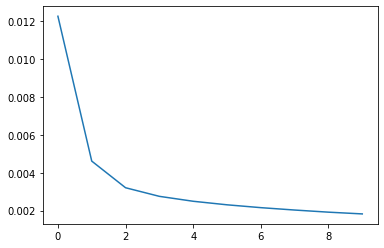

In [ ]:
plt.plot(train_loss[:, 0], label = 'Training MNIST')
#plt.plot(val_loss[:, 0], label = 'Validation MNIST')
plt.plot(train_loss[:, 1], label = 'Training Fashion MNIST')
#plt.plot(val_loss[:, 1], label = 'Validation Fashion MNIST')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

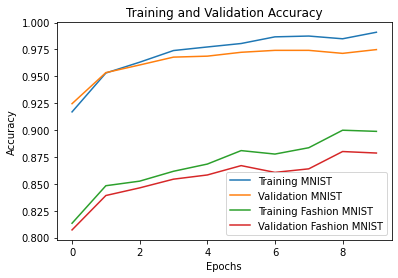

In [ ]:
plt.plot(train_accuracy[:, 0], label = 'Training MNIST')
plt.plot(val_accuracy[:, 0], label = 'Validation MNIST')
plt.plot(train_accuracy[:, 1], label = 'Training Fashion MNIST')
plt.plot(val_accuracy[:, 1], label = 'Validation Fashion MNIST')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

## Bias vs. Variance

In [ ]:
# built-in algorithm
built_in = ['Adam']
# built_in = ['SGD', 'Adam', 'RMSEProp']

# storage
num_alg = len(built_in)
num_model = 2 # 0 for no regularization 1 for regularization
num_rep = 10
num_dataset = 2  # 0 for MNIST 1 for FMNIST

test_accuracy = np.zeros([num_rep, num_alg, num_model, num_dataset])
used_time = np.zeros([num_rep, num_alg, num_model])

In [ ]:
for index_alg, alg in enumerate(built_in):
  for n in range(num_rep):
    print(alg, n)

    # Set number of epochs
    NUM_EPOCHS = 10

    # Initialize model without regularization
    # , regularizer = 'L2', L1_alpha = 1 , regularizer = 'L2', L1_alpha = 1 , device='gpu' optimizer = 'Adam', 
    mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, lr = 1e-2, device = 'gpu', optimizer = alg) #, regularizer = 'L2', L2_alpha = 0.1,
    mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, lr = 1e-2, device = 'gpu', optimizer = alg) #, regularizer = 'L2', L2_alpha = 0.1,
    
    time_start = time.time()
    for epoch in range(NUM_EPOCHS):

      # MNIST
      train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
      for inputs, outputs in train_ds:
        mlp_on_cpu.backward(inputs, outputs)
      # FMNIST
      train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
      for inputs, outputs in train_ds_fs:
        mlp_on_cpu_fs.backward(inputs, outputs)
    time_taken = time.time() - time_start

    # record time
    used_time[n, index_alg, 0] = time_taken

    # test sample
    # for MNIST
    preds = mlp_on_cpu.forward(X_test)
    preds = tf.nn.softmax(preds)
    correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_test, 1))
    test_accuracy[n, index_alg, 0, 0] = tf.reduce_mean(tf.cast(correct_preds, 'float'))
    # for Fashion MNIST
    preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
    preds_fs = tf.nn.softmax(preds_fs)
    correct_preds_fs = tf.equal(tf.argmax(preds_fs, 1), tf.argmax(y_test_fs, 1))
    test_accuracy[n, index_alg, 0, 1] = tf.reduce_mean(tf.cast(correct_preds_fs, 'float'))




    # Initialize model with regularization
    # , regularizer = 'L2', L1_alpha = 1 , regularizer = 'L2', L1_alpha = 1 , device='gpu' optimizer = 'Adam', 
    mlp_on_cpu = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, lr = 1e-2, device = 'gpu', optimizer = alg, regularizer = 'L2', L2_alpha = 0.02)
    mlp_on_cpu_fs = MLP_QZ(size_data, size_input, size_hidden_1, size_hidden_2, size_output, lr = 1e-2, device = 'gpu', optimizer = alg, regularizer = 'L2', L2_alpha = 0.02)
    
    time_start = time.time()
    for epoch in range(NUM_EPOCHS):

      # MNIST
      train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(batch_size_train)
      for inputs, outputs in train_ds:
        mlp_on_cpu.backward(inputs, outputs)
      # FMNIST
      train_ds_fs = tf.data.Dataset.from_tensor_slices((X_train_fs, y_train_fs)).shuffle(100).batch(batch_size_train)
      for inputs, outputs in train_ds_fs:
        mlp_on_cpu_fs.backward(inputs, outputs)
    time_taken = time.time() - time_start

    # record time
    used_time[n, index_alg, 1] = time_taken
      
    # test sample
    # for MNIST
    preds = mlp_on_cpu.forward(X_test)
    preds = tf.nn.softmax(preds)
    correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(y_test, 1))
    test_accuracy[n, index_alg, 1, 0] = tf.reduce_mean(tf.cast(correct_preds, 'float'))
    # for Fashion MNIST
    preds_fs = mlp_on_cpu_fs.forward(X_test_fs)
    preds_fs = tf.nn.softmax(preds_fs)
    correct_preds_fs = tf.equal(tf.argmax(preds_fs, 1), tf.argmax(y_test_fs, 1))
    test_accuracy[n, index_alg, 1, 1] = tf.reduce_mean(tf.cast(correct_preds_fs, 'float'))

Adam 0
Adam 1
Adam 2
Adam 3
Adam 4
Adam 5
Adam 6
Adam 7
Adam 8
Adam 9


In [ ]:
test_accuracy[:, 0, 1, :]

array([[0.79579997, 0.51899999],
       [0.73989999, 0.40549999],
       [0.68660003, 0.48899999],
       [0.80830002, 0.5424    ],
       [0.7726    , 0.50830001],
       [0.73629999, 0.59579998],
       [0.80690002, 0.60339999],
       [0.75520003, 0.53680003],
       [0.7295    , 0.54409999],
       [0.76899999, 0.6124    ]])

In [ ]:
used_time[:, 0, :]

array([[278.64154482, 278.17490983],
       [244.34871507, 266.33649921],
       [240.80667472, 261.70369172],
       [243.9208281 , 265.88206029],
       [241.77546477, 263.84540367],
       [241.01366878, 264.95406127],
       [247.79385567, 271.44136834],
       [240.84248638, 262.31962681],
       [239.20214462, 263.42726064],
       [238.40954947, 267.26508331]])